# Homework 2: Considering Bias in Data

In this homework, we explore the concept of bias in data using Wikipedia article. We will consider articles on political figures from different countries. 

## Step 1: Importing necessary library

In [1]:
import json, time, urllib.parse
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

## Step 2: Importing Data

* The politicans dataset is generated by crawling a list of Wikipedia article pages about politicians from a wide range of countries. 
* The population dataset is drawn from the world population data sheet published by the Population Reference Bureau.


In [2]:
politicians = pd.read_csv("politicians_by_country_SEPT.2022.csv - politicians_international_SEPT.2022.csv")
populations = pd.read_csv("population_by_country_2022.csv - population_by_country_2022.csv")

In [3]:
politicians.head()

,name,url,country
0,Shahjahan Noori,https://en.wikipedia.org/wiki/Shahjahan_Noori,Afghanistan
1,Abdul Ghafar Lakanwal,https://en.wikipedia.org/wiki/Abdul_Ghafar_Lak...,Afghanistan
2,Majah Ha Adrif,https://en.wikipedia.org/wiki/Majah_Ha_Adrif,Afghanistan
3,Haroon al-Afghani,https://en.wikipedia.org/wiki/Haroon_al-Afghani,Afghanistan
4,Tayyab Agha,https://en.wikipedia.org/wiki/Tayyab_Agha,Afghanistan


In [4]:
populations.head()

,Geography,Population (millions)
0,WORLD,7963.0
1,AFRICA,1419.0
2,NORTHERN AFRICA,251.0
3,Algeria,44.9
4,Egypt,103.5


## Step 3: Obtaining the Article Page Info from the MediaWiki API

We access the page info data using the MediaWiki REST API for the EN Wikipedia.

* 3.1 Defining Constants to be used in API Call
* 3.2 Defining API Request function, where the input will be the Article name and the output will be the article information
* 3.3 Parsing through list to obtain the Politician Name and Revision id for each article. Adding the values to a new dataframe

In [5]:
# 3.1 Defining Constants to be used in API Call


API_ENWIKIPEDIA_ENDPOINT = "https://en.wikipedia.org/w/api.php"

# Adding latency ensures we dont overcrowd the free resource
API_LATENCY_ASSUMED = 0.002       
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# Including information about the person making the request
REQUEST_HEADERS = {
    'User-Agent': '<reeyabp@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This is a string of additional page properties that can be returned see the Info documentation for
# what can be included. If you don't want any this can simply be the empty string
PAGEINFO_EXTENDED_PROPERTIES = "talkid|url|watched|watchers"
#PAGEINFO_EXTENDED_PROPERTIES = ""

# This template lists the basic parameters for making this
PAGEINFO_PARAMS_TEMPLATE = {
    "action": "query",
    "format": "json",
    "titles": "",           # to simplify this should be a single page title at a time
    "prop": "info",
    "inprop": PAGEINFO_EXTENDED_PROPERTIES
}

In [6]:
##  3.2 Defining API Request function, where the input will be the Article name and the output will be the article information


def request_pageinfo_per_article(article_title = None, 
                                 endpoint_url = API_ENWIKIPEDIA_ENDPOINT, 
                                 request_template = PAGEINFO_PARAMS_TEMPLATE,
                                 headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    request_template['titles'] = article_title
        
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or any other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(endpoint_url, headers=headers, params=request_template)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

3.3 Parsing through list to obtain the Politician Name and Revision id for each article. Adding the values to a new dataframe

In [7]:
# info_all is a list of dictionaries 

info_all = []

for p in range(0,len(politicians),50):

    info = request_pageinfo_per_article('|'.join(politicians['name'][p:p+50]))
    info_all.extend(list(info['query']['pages'].values()))
                                        

In [8]:
info_all

[{'pageid': 65412901,
  'ns': 0,
  'title': 'Abas Basir',
  'contentmodel': 'wikitext',
  'pagelanguage': 'en',
  'pagelanguagehtmlcode': 'en',
  'pagelanguagedir': 'ltr',
  'touched': '2022-10-11T01:20:40Z',
  'lastrevid': 1098419766,
  'length': 19306,
  'talkid': 65415333,
  'fullurl': 'https://en.wikipedia.org/wiki/Abas_Basir',
  'editurl': 'https://en.wikipedia.org/w/index.php?title=Abas_Basir&action=edit',
  'canonicalurl': 'https://en.wikipedia.org/wiki/Abas_Basir'},
 {'pageid': 27428272,
  'ns': 0,
  'title': 'Abdul Baqi Turkistani',
  'contentmodel': 'wikitext',
  'pagelanguage': 'en',
  'pagelanguagehtmlcode': 'en',
  'pagelanguagedir': 'ltr',
  'touched': '2022-10-11T03:06:55Z',
  'lastrevid': 889226470,
  'length': 1297,
  'talkid': 27595416,
  'fullurl': 'https://en.wikipedia.org/wiki/Abdul_Baqi_Turkistani',
  'editurl': 'https://en.wikipedia.org/w/index.php?title=Abdul_Baqi_Turkistani&action=edit',
  'canonicalurl': 'https://en.wikipedia.org/wiki/Abdul_Baqi_Turkistani'},


In [9]:
# Converting the list of dictionaries into a DataFrame with 2 columns

info_df = pd.DataFrame.from_dict(info_all)[['title', 'lastrevid']]
info_df.head()

,title,lastrevid
0,Abas Basir,1.098420e+09
1,Abdul Baqi Turkistani,8.892265e+08
2,Abdul Ghafar Lakanwal,9.435623e+08
3,Abdul Ghani Ghani,1.072442e+09
4,Abdul Malik Hamwar,1.100875e+09


In [10]:
print("Number of politicians = ", len(info_df))
info_df.head()

Number of politicians =  7584


,title,lastrevid
0,Abas Basir,1.098420e+09
1,Abdul Baqi Turkistani,8.892265e+08
2,Abdul Ghafar Lakanwal,9.435623e+08
3,Abdul Ghani Ghani,1.072442e+09
4,Abdul Malik Hamwar,1.100875e+09


## List of politicians with missing Revision IDs after passing it through the API Call

In [11]:
politicians_missing_revid = info_df[info_df['lastrevid'].isnull()]
politicians_missing_revid

,title,lastrevid
2400,Hopeson Adorye,NaN
2401,Prince Ofosu Sefah,NaN
2950,Harjit Kaur Talwandi,NaN
3200,Abd al-Razzaq al-Hasani,NaN
4850,Abiodun Abimbola Orekoya,NaN
5800,Roman Konoplev,NaN


In [12]:
print("Total Number of politicians = ", len(info_df))

info_df.dropna(inplace=True)
print("Number of politicians after removing missing Rev IDs = ", len(info_df))

info_df.head()

Total Number of politicians =  7584
Number of politicians after removing missing Rev IDs =  7578


,title,lastrevid
0,Abas Basir,1.098420e+09
1,Abdul Baqi Turkistani,8.892265e+08
2,Abdul Ghafar Lakanwal,9.435623e+08
3,Abdul Ghani Ghani,1.072442e+09
4,Abdul Malik Hamwar,1.100875e+09


## Step 4: Generating quality scores for article revisions using ORES API

The API documentation can be access from the main [ORES](https://ores.wikimedia.org) page

* 4.1 Defining Constants to be used in API Call
* 4.2 Defining API Request function, where the input will be the Article name and the output will be the article information
* 4.3 Converting the API output into a Dataframe called ores_result

####  4.1 Defining Constants to be used in API Call

In [13]:
# The current ORES API endpoint
API_ORES_SCORE_ENDPOINT = "https://ores.wikimedia.org/v3"

# A template for mapping to the URL
API_ORES_SCORE_PARAMS = "/scores/{context}/?models={model}&revids={revid}"

# Use some delays so that we do not hammer the API with our requests
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making automated requests we should include something that is unique to the person making the request
# This should include an email - your UW email would be good to put in there
REQUEST_HEADERS = {
    'User-Agent': '<reeyabp@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022'
}

# A dictionary of English Wikipedia article titles (keys) and sample revision IDs that can be used for this ORES scoring example
ARTICLE_REVISIONS = { 'Bison':1085687913 , 'Northern flicker':1086582504 , 'Red squirrel':1083787665 , 'Chinook salmon':1085406228 , 'Horseshoe bat':1060601936 }

# This template lists the basic parameters for making an ORES request
ORES_PARAMS_TEMPLATE = {
    "context": "enwiki",        # which WMF project for the specified revid
    "revid" : "",               # the revision to be scored - this will probably change each call
    "model": "articlequality"   # the AI/ML scoring model to apply to the reviewion
}

#### 4.2 Defining API Request function, where the input will be the Article name and the output will be the article information

In [14]:
def request_ores_score_per_article(article_revid = None, 
                                   endpoint_url = API_ORES_SCORE_ENDPOINT, 
                                   endpoint_params = API_ORES_SCORE_PARAMS, 
                                   request_template = ORES_PARAMS_TEMPLATE,
                                   headers = REQUEST_HEADERS,
                                   features=False):
    # Make sure we have an article revision id
    if not article_revid: return None
    
    # set the revision id into the template
    request_template['revid'] = article_revid
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # the features used by the ML model can sometimes be returned as well as scores
    if features:
        request_url = request_url+"?features=true"
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like ORES - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [15]:
# We define ARTICLE_REVISIONS as a list of RevisionIDs which will be passed as input to the ORES API call

ARTICLE_REVISIONS  = info_df['lastrevid'].map(int).map(str)

#### 4.3 Converting the API output into a Dataframe called ores_result

In [16]:
# scores_all stores the prediction for each Revision ID

scores_all = []
rev_id = []
idx = []

for p in range(0,len(ARTICLE_REVISIONS),50):

    score = request_ores_score_per_article('|'.join(ARTICLE_REVISIONS[p:p+50]))
    keys = list(score['enwiki']['scores'].keys())
    idx.extend(keys)
    rev_id.extend(keys)
    scores_all.extend(list(map(lambda key: score['enwiki']['scores'][key]['articlequality']['score']['prediction'],keys)))
  

In [17]:
#score_all stores the list of predictions

ores_result = pd.DataFrame(
    {'prediction': scores_all,
     'revid': rev_id})

ores_result.head()

,prediction,revid
0,Stub,1013838830
1,Stub,1033383351
2,Start,1038918070
3,B,1041460606
4,Start,1060707209


## Step 5: Data Manipulation

5.1 Joining 3 tables to form the final politicians dataset:
* Politician table (from csv file) 
* info_df which contains the Revision ID for each Article
* ores_result which contains the Revision ID and associated Prediction grade

5.2 Adding the Region to the Population dataset
* Duplicate the Geography column to "Region"
* Remove all values in the lowercase, as these will be Country names and not Region names
* Use the function ffill() to forward fill the Regions

5.3 Joining all tables to get the final_dataset before starting the Analysis
* Joining the Populations dataset, with our regions from 5.2, to create the dataset

5.4 Identify all countries for which there are no matches and output a list of those countries, with each country on a separate line
* Using the original Populations dataset, we have the list of total countries. We join this with the final_dataset which contains the ORES result. If any country from the Populations set has a missing ORES prediction, then we will add this country to our new list countries_excluded
* Save it as a csv file labeled 'wp_countries-no_match.txt'

In [18]:
print("Table: Politicians")
print(politicians.head())

print("\n\nTable: info_df")
print(info_df.head())


print("\n\nTable: ores_result")
print(ores_result.head())


Table: Politicians
                    name                                                url  \
0        Shahjahan Noori      https://en.wikipedia.org/wiki/Shahjahan_Noori   
1  Abdul Ghafar Lakanwal  https://en.wikipedia.org/wiki/Abdul_Ghafar_Lak...   
2         Majah Ha Adrif       https://en.wikipedia.org/wiki/Majah_Ha_Adrif   
3      Haroon al-Afghani    https://en.wikipedia.org/wiki/Haroon_al-Afghani   
4            Tayyab Agha          https://en.wikipedia.org/wiki/Tayyab_Agha   

       country  
0  Afghanistan  
1  Afghanistan  
2  Afghanistan  
3  Afghanistan  
4  Afghanistan  


Table: info_df
                   title     lastrevid
0             Abas Basir  1.098420e+09
1  Abdul Baqi Turkistani  8.892265e+08
2  Abdul Ghafar Lakanwal  9.435623e+08
3      Abdul Ghani Ghani  1.072442e+09
4     Abdul Malik Hamwar  1.100875e+09


Table: ores_result
  prediction       revid
0       Stub  1013838830
1       Stub  1033383351
2      Start  1038918070
3          B  1041460606
4      

#### 5.1 Joining 3 tables to form the final politicians dataset:

#### Joining the Politician table (from csv file) with info_df which contains the Revision ID for each Article

In [19]:
## Joining two tables 

# Politicians contains the Title, URL, Country
# Info_df contains the Title and RevisionID


politicians_revid = pd.merge(info_df, politicians,how ="left", left_on= "title", right_on = "name")
len(politicians_revid)
politicians_revid.head()

,title,lastrevid,name,url,country
0,Abas Basir,1.098420e+09,Abas Basir,https://en.wikipedia.org/wiki/Abas_Basir,Afghanistan
1,Abdul Baqi Turkistani,8.892265e+08,Abdul Baqi Turkistani,https://en.wikipedia.org/wiki/Abdul_Baqi_Turki...,Afghanistan
2,Abdul Ghafar Lakanwal,9.435623e+08,Abdul Ghafar Lakanwal,https://en.wikipedia.org/wiki/Abdul_Ghafar_Lak...,Afghanistan
3,Abdul Ghani Ghani,1.072442e+09,Abdul Ghani Ghani,https://en.wikipedia.org/wiki/Abdul_Ghani_Ghani,Afghanistan
4,Abdul Malik Hamwar,1.100875e+09,Abdul Malik Hamwar,https://en.wikipedia.org/wiki/Abdul_Malik_Hamwar,Afghanistan


In [20]:
politicians_revid["lastrevid"] = politicians_revid["lastrevid"].astype(int)
politicians_revid["lastrevid"]

0       1098419766
1        889226470
2        943562276
3       1072441893
4       1100874645
           ...    
7679    1112385169
7680    1110541985
7681    1073818982
7682    1091958972
7683    1035940114
Name: lastrevid, Length: 7684, dtype: int64

In [21]:
ores_result["revid"] = ores_result["revid"].astype(int)
ores_result["revid"]

0       1013838830
1       1033383351
2       1038918070
3       1041460606
4       1060707209
           ...    
7573    1112385169
7574    1112725980
7575    1114641622
7576     904246837
7577     959111842
Name: revid, Length: 7578, dtype: int64

#### Joining the politicians_revid table with ores_result which contains the Prediction for each Revision ID

In [22]:
## Joining two tables 

# ores_result contains the RevisionID and ORES Prediction score
# Joining the two tables using an inner join

politician_ores = pd.merge(politicians_revid, ores_result, how = 'left',left_on="lastrevid", right_on = "revid")
politician_ores.drop_duplicates(inplace=True)
len(politician_ores)

7576

In [23]:
# Final Politicians dataset with Revision ID and Prediction
politician_ores.head()

,title,lastrevid,name,url,country,prediction,revid
0,Abas Basir,1098419766,Abas Basir,https://en.wikipedia.org/wiki/Abas_Basir,Afghanistan,C,1098419766
1,Abdul Baqi Turkistani,889226470,Abdul Baqi Turkistani,https://en.wikipedia.org/wiki/Abdul_Baqi_Turki...,Afghanistan,Stub,889226470
2,Abdul Ghafar Lakanwal,943562276,Abdul Ghafar Lakanwal,https://en.wikipedia.org/wiki/Abdul_Ghafar_Lak...,Afghanistan,Start,943562276
3,Abdul Ghani Ghani,1072441893,Abdul Ghani Ghani,https://en.wikipedia.org/wiki/Abdul_Ghani_Ghani,Afghanistan,Stub,1072441893
4,Abdul Malik Hamwar,1100874645,Abdul Malik Hamwar,https://en.wikipedia.org/wiki/Abdul_Malik_Hamwar,Afghanistan,Stub,1100874645


##### 5.2 Adding the Region to the Population dataset

In [24]:
# Making a duplicate of the Populations table 

copopulations = populations
copopulations['region'] = populations['Geography']
copopulations['region'] = copopulations['region'].map(lambda x: None if x.isupper() is False else x)
copopulations.loc[:,'region'] = copopulations.loc[:,'region'].ffill() 


copopulations.head()

,Geography,Population (millions),region
0,WORLD,7963.0,WORLD
1,AFRICA,1419.0,AFRICA
2,NORTHERN AFRICA,251.0,NORTHERN AFRICA
3,Algeria,44.9,NORTHERN AFRICA
4,Egypt,103.5,NORTHERN AFRICA


##### 5.3 Joining all tables to get the final_dataset before starting the Analysis

In [25]:
final_dataset = pd.merge(politician_ores,copopulations, left_on = "country",right_on= "Geography")
final_dataset.head()

,title,lastrevid,name,url,country,prediction,revid,Geography,Population (millions),region
0,Abas Basir,1098419766,Abas Basir,https://en.wikipedia.org/wiki/Abas_Basir,Afghanistan,C,1098419766,Afghanistan,41.1,SOUTH ASIA
1,Abdul Baqi Turkistani,889226470,Abdul Baqi Turkistani,https://en.wikipedia.org/wiki/Abdul_Baqi_Turki...,Afghanistan,Stub,889226470,Afghanistan,41.1,SOUTH ASIA
2,Abdul Ghafar Lakanwal,943562276,Abdul Ghafar Lakanwal,https://en.wikipedia.org/wiki/Abdul_Ghafar_Lak...,Afghanistan,Start,943562276,Afghanistan,41.1,SOUTH ASIA
3,Abdul Ghani Ghani,1072441893,Abdul Ghani Ghani,https://en.wikipedia.org/wiki/Abdul_Ghani_Ghani,Afghanistan,Stub,1072441893,Afghanistan,41.1,SOUTH ASIA
4,Abdul Malik Hamwar,1100874645,Abdul Malik Hamwar,https://en.wikipedia.org/wiki/Abdul_Malik_Hamwar,Afghanistan,Stub,1100874645,Afghanistan,41.1,SOUTH ASIA


In [26]:
#final_dataset.drop(columns = 'Geography', inplace = True)
final_dataset.rename(columns={'name': 'article_title', 'lastrevid': 'revision_id','prediction':'article_quality',
                             'Population (millions)':'population'}, inplace=True)
final_dataset.drop_duplicates(inplace=True)
final_dataset.head()

,title,revision_id,article_title,url,country,article_quality,revid,Geography,population,region
0,Abas Basir,1098419766,Abas Basir,https://en.wikipedia.org/wiki/Abas_Basir,Afghanistan,C,1098419766,Afghanistan,41.1,SOUTH ASIA
1,Abdul Baqi Turkistani,889226470,Abdul Baqi Turkistani,https://en.wikipedia.org/wiki/Abdul_Baqi_Turki...,Afghanistan,Stub,889226470,Afghanistan,41.1,SOUTH ASIA
2,Abdul Ghafar Lakanwal,943562276,Abdul Ghafar Lakanwal,https://en.wikipedia.org/wiki/Abdul_Ghafar_Lak...,Afghanistan,Start,943562276,Afghanistan,41.1,SOUTH ASIA
3,Abdul Ghani Ghani,1072441893,Abdul Ghani Ghani,https://en.wikipedia.org/wiki/Abdul_Ghani_Ghani,Afghanistan,Stub,1072441893,Afghanistan,41.1,SOUTH ASIA
4,Abdul Malik Hamwar,1100874645,Abdul Malik Hamwar,https://en.wikipedia.org/wiki/Abdul_Malik_Hamwar,Afghanistan,Stub,1100874645,Afghanistan,41.1,SOUTH ASIA


In [27]:
# Reordering of columns in the dataframe
final_dataset = final_dataset.iloc[:,[1,2,5,4,0,3,8,9]]

In [28]:
final_dataset.to_csv('wp_politicians_by_country.csv', encoding='utf-8', index=False, header = True)

### 5.4 Identify all countries for which there are no matches and output a list of those countries, with each country on a separate line

In [29]:
print("Number of Unique countries in our Population dataset: ", len(populations))
print("Number of Unique countries in the final_dataset after adding the ORES scores: ",len(final_dataset['country'].unique()))

Number of Unique countries in our Population dataset:  233
Number of Unique countries in the final_dataset after adding the ORES scores:  184


In [30]:
len(final_dataset['country'].unique())

184

In [31]:
#Removing Region column from the population dataset

populations_only_countries = populations.drop(columns='region')

#Replace all Region values in the 'Geography' column with None
populations_only_countries = populations_only_countries['Geography'].map(lambda x: None if x.isupper() is True else x)

# Removing all rows with None values. Thus we're only left with Countries 
populations_only_countries = populations_only_countries.replace(to_replace='None', value=np.nan).dropna()

In [32]:
len(populations_only_countries)

209

In [33]:
countries_excluded = pd.merge(populations_only_countries, final_dataset, how= 'left',left_on = 'Geography', right_on = 'country')
countries_excluded = countries_excluded[countries_excluded['country'].isna()] 

countries_excluded.drop(columns=['article_title','revision_id','url','country','article_quality']
, inplace = True)

In [34]:
countries_excluded.to_csv('wp_countries-no_match.txt', encoding='utf-8', index=False, header = False)

## Step 6: Analysis

Your analysis will consist of calculating total-articles-per-population (a ratio representing the number of articles per person)  and high-quality-articles-per-population (a ratio representing the number of high quality articles per person) on a country-by-country and regional basis. All of these values are to be “per capita”.

In this analysis a country can only exist in one region. The population_by_country_2022.csv actually represents regions in a hierarchical order. For your analysis always put a country in the closest (lowest in the hierarchy) region.

For this analysis you should consider "high quality" articles to be articles that ORES predicted would be in either the "FA" (featured article) or "GA" (good article) classes.
Also, keep in mind that the population_by_country_2022.csv file provides population in millions. The calculated proportions in this step are likely to be very small numbers.


In [35]:
final_dataset

,revision_id,article_title,article_quality,country,title,url,population,region
0,1098419766,Abas Basir,C,Afghanistan,Abas Basir,https://en.wikipedia.org/wiki/Abas_Basir,41.1,SOUTH ASIA
1,889226470,Abdul Baqi Turkistani,Stub,Afghanistan,Abdul Baqi Turkistani,https://en.wikipedia.org/wiki/Abdul_Baqi_Turki...,41.1,SOUTH ASIA
2,943562276,Abdul Ghafar Lakanwal,Start,Afghanistan,Abdul Ghafar Lakanwal,https://en.wikipedia.org/wiki/Abdul_Ghafar_Lak...,41.1,SOUTH ASIA
3,1072441893,Abdul Ghani Ghani,Stub,Afghanistan,Abdul Ghani Ghani,https://en.wikipedia.org/wiki/Abdul_Ghani_Ghani,41.1,SOUTH ASIA
4,1100874645,Abdul Malik Hamwar,Stub,Afghanistan,Abdul Malik Hamwar,https://en.wikipedia.org/wiki/Abdul_Malik_Hamwar,41.1,SOUTH ASIA
...,...,...,...,...,...,...,...,...
7501,1098315530,Patrick Chikusu,Start,Zambia,Patrick Chikusu,https://en.wikipedia.org/wiki/Patrick_Chikusu,20.0,EASTERN AFRICA
7502,1105649973,Peter Sinkamba,Start,Zambia,Peter Sinkamba,https://en.wikipedia.org/wiki/Peter_Sinkamba,20.0,EASTERN AFRICA
7503,1090872335,Rosaria C. Fundanga,Stub,Zambia,Rosaria C. Fundanga,https://en.wikipedia.org/wiki/Rosaria_C._Fundanga,20.0,EASTERN AFRICA
7504,1081291691,Sylvia Bambala Chalikosa,Stub,Zambia,Sylvia Bambala Chalikosa,https://en.wikipedia.org/wiki/Sylvia_Bambala_C...,20.0,EASTERN AFRICA


### 1. Top 10 countries by coverage: The 10 countries with the highest total articles per capita (in descending order)

In [36]:
df = (final_dataset.groupby('country')['revision_id'].count()/(final_dataset.groupby('country')['population'].mean()*1000000)).to_frame(name='totalarticles_per_capita').reset_index()

# Removing values equal to inf
df1 = df.replace(np.inf, np.nan).dropna(axis=0)
df1 = df1.sort_values('totalarticles_per_capita', ascending= False).head(10)
df1

,country,totalarticles_per_capita
5,Antigua and Barbuda,0.000170
54,Federated States of Micronesia,0.000130
3,Andorra,0.000100
13,Barbados,0.000093
104,Marshall Islands,0.000090
143,Seychelles,0.000060
110,Montenegro,0.000060
97,Luxembourg,0.000053
18,Bhutan,0.000051
64,Grenada,0.000050


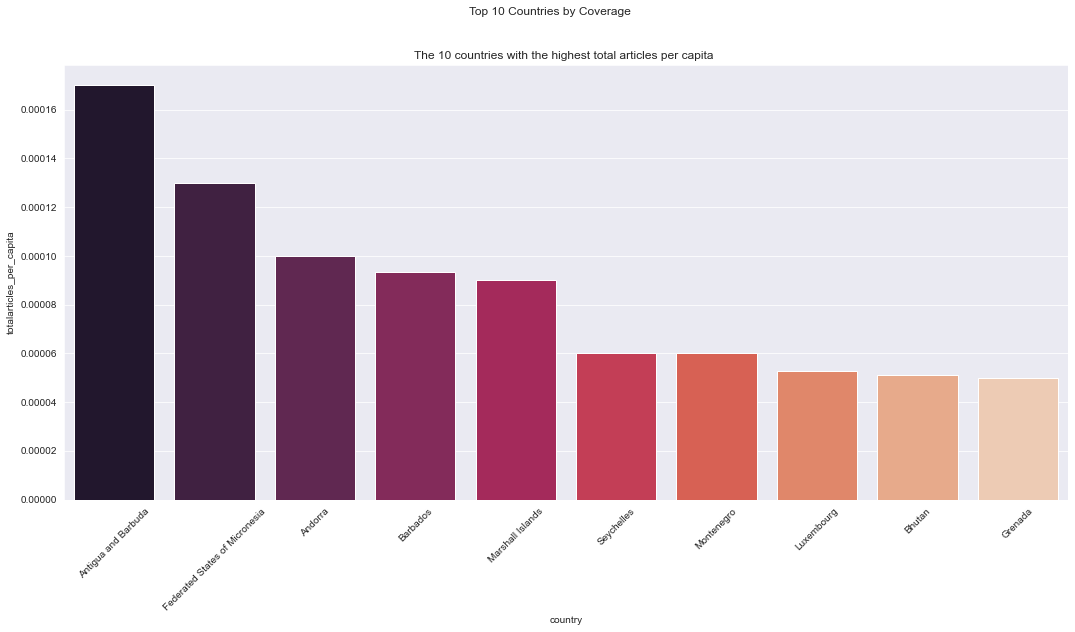

In [37]:
plt.figure(figsize=(18,8))
sns.set_style("darkgrid")
ax = sns.barplot(x='country', y="totalarticles_per_capita", data=df1, palette = 'rocket')
for item in ax.get_xticklabels(): item.set_rotation(45)
ax.set(title=' Top 10 Countries by Coverage')
plt.suptitle("Top 10 Countries by Coverage")
plt.title("The 10 countries with the highest total articles per capita ")
sns.set(font_scale=2)
plt.show()

### 2. Bottom 10 countries by coverage: The 10 countries with the lowest total articles per capita (in ascending order)

In [38]:
df2 = df.sort_values('totalarticles_per_capita', ascending= True).head(10)
df2

,country,totalarticles_per_capita
32,China,1.392176e-09
106,Mexico,7.843137e-09
140,Saudi Arabia,8.174387e-08
134,Romania,1.052632e-07
73,India,1.255998e-07
153,Sri Lanka,1.339286e-07
48,Egypt,1.352657e-07
53,Ethiopia,2.025932e-07
161,Taiwan,2.155172e-07
180,Vietnam,2.716298e-07


### 3. Top 10 countries by high quality: The 10 countries with the highest high quality articles per capita (in descending order) .

In [39]:
high_quality_dataset = final_dataset[(final_dataset['article_quality']== 'FA') | (final_dataset['article_quality']== 'GA')]
high_quality_dataset['article_quality'].unique()

df31 = (high_quality_dataset.groupby('country')['revision_id'].count()/(high_quality_dataset.groupby('country')['population'].mean()*1000000)).to_frame(name='totalarticles_per_capita').reset_index().replace(np.inf, np.nan).dropna(axis=0)
df3 = df31.sort_values('totalarticles_per_capita',ascending= False).head(10)
df3

,country,totalarticles_per_capita
2,Andorra,2.000000e-05
53,Montenegro,5.000000e-06
1,Albania,2.142857e-06
80,Suriname,1.666667e-06
9,Bosnia-Herzegovina,1.470588e-06
49,Lithuania,1.071429e-06
19,Croatia,1.052632e-06
74,Slovenia,9.523810e-07
61,Palestinian Territory,9.259259e-07
28,Gabon,8.333333e-07


### 4. Bottom 10 countries by high quality: The 10 countries with the lowest high quality articles per capita (in ascending order).

In [40]:
df4 = df31.sort_values('totalarticles_per_capita',ascending= True).head(10)
df4

,country,totalarticles_per_capita
35,India,4.233700e-09
84,Thailand,1.497006e-08
39,Japan,1.601281e-08
58,Nigeria,1.830664e-08
91,Vietnam,2.012072e-08
17,Colombia,2.036660e-08
87,Uganda,2.118644e-08
60,Pakistan,2.120441e-08
79,Sudan,2.132196e-08
37,Iran,2.257336e-08


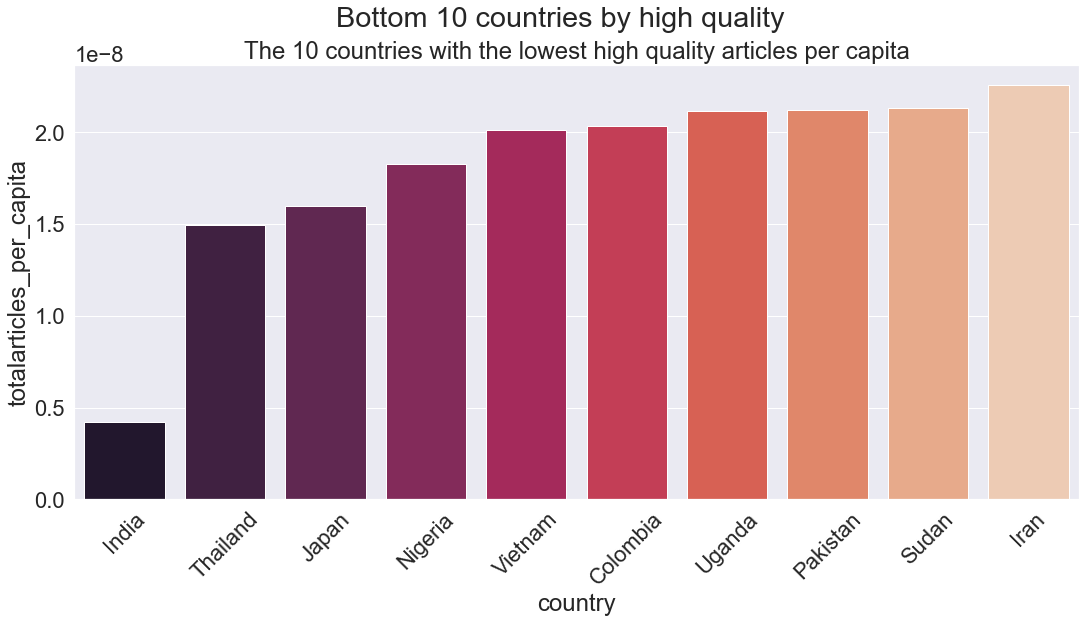

In [41]:
plt.figure(figsize=(18,8))
sns.set_style("darkgrid")
ax = sns.barplot(x='country', y="totalarticles_per_capita", data=df4, palette = 'rocket')
for item in ax.get_xticklabels(): item.set_rotation(45)
plt.suptitle("Bottom 10 countries by high quality")
plt.title("The 10 countries with the lowest high quality articles per capita")
sns.set(font_scale=2)
plt.show()

### 5. Geographic regions by total coverage: A rank ordered list of geographic regions (in descending order) by total articles per capita.

In [42]:
region_populations = copopulations[copopulations['Geography']==copopulations['region'] ]
region_populations.rename(columns={'Population (millions)': 'region_population'}, inplace=True)
region_populations.drop('Geography', axis=1, inplace= True)
region_populations.head()

,region_population,region
0,7963.0,WORLD
1,1419.0,AFRICA
2,251.0,NORTHERN AFRICA
10,430.0,WESTERN AFRICA
27,473.0,EASTERN AFRICA


In [43]:
df5 = pd.merge(final_dataset, region_populations, how = 'inner', on = 'region')
df5.head()

,revision_id,article_title,article_quality,country,title,url,population,region,region_population
0,1098419766,Abas Basir,C,Afghanistan,Abas Basir,https://en.wikipedia.org/wiki/Abas_Basir,41.1,SOUTH ASIA,2008.0
1,889226470,Abdul Baqi Turkistani,Stub,Afghanistan,Abdul Baqi Turkistani,https://en.wikipedia.org/wiki/Abdul_Baqi_Turki...,41.1,SOUTH ASIA,2008.0
2,943562276,Abdul Ghafar Lakanwal,Start,Afghanistan,Abdul Ghafar Lakanwal,https://en.wikipedia.org/wiki/Abdul_Ghafar_Lak...,41.1,SOUTH ASIA,2008.0
3,1072441893,Abdul Ghani Ghani,Stub,Afghanistan,Abdul Ghani Ghani,https://en.wikipedia.org/wiki/Abdul_Ghani_Ghani,41.1,SOUTH ASIA,2008.0
4,1100874645,Abdul Malik Hamwar,Stub,Afghanistan,Abdul Malik Hamwar,https://en.wikipedia.org/wiki/Abdul_Malik_Hamwar,41.1,SOUTH ASIA,2008.0


In [44]:
#  A rank ordered list of geographic regions (in descending order) by total articles per capita.

df5 = (df5.groupby('region')['revision_id'].count()/(df5.groupby('region')['region_population'].mean()*1000000)).to_frame(name='totalarticles_per_capita').reset_index()
df5.sort_values('totalarticles_per_capita',ascending= False)

,region,totalarticles_per_capita
14,SOUTHERN EUROPE,5.894040e-06
0,CARIBBEAN,4.568182e-06
17,WESTERN EUROPE,3.548223e-06
5,EASTERN EUROPE,2.560976e-06
8,NORTHERN EUROPE,2.448598e-06
16,WESTERN ASIA,2.333333e-06
9,OCEANIA,1.954545e-06
13,SOUTHERN AFRICA,1.710145e-06
4,EASTERN AFRICA,1.369979e-06
2,CENTRAL ASIA,1.358974e-06


### 6. Geographic regions by high quality coverage: Rank ordered list of geographic regions (in descending order) by high quality articles per capita.

In [45]:
high_quality_dataset

,revision_id,article_title,article_quality,country,title,url,population,region
46,1099689043,Shahjahan Noori,GA,Afghanistan,Shahjahan Noori,https://en.wikipedia.org/wiki/Shahjahan_Noori,41.1,SOUTH ASIA
55,1090245979,Ahmed Wali Karzai,GA,Afghanistan,Ahmed Wali Karzai,https://en.wikipedia.org/wiki/Ahmed_Wali_Karzai,41.1,SOUTH ASIA
59,1115022704,Amrullah Saleh,FA,Afghanistan,Amrullah Saleh,https://en.wikipedia.org/wiki/Amrullah_Saleh,41.1,SOUTH ASIA
76,1103105365,Masoud Khalili,GA,Afghanistan,Masoud Khalili,https://en.wikipedia.org/wiki/Masoud_Khalili,41.1,SOUTH ASIA
101,1106388504,Abdul Salam Zaeef,GA,Afghanistan,Abdul Salam Zaeef,https://en.wikipedia.org/wiki/Abdul_Salam_Zaeef,41.1,SOUTH ASIA
...,...,...,...,...,...,...,...,...
7238,1114683691,Luis Almagro,GA,Uruguay,Luis Almagro,https://en.wikipedia.org/wiki/Luis_Almagro,3.6,SOUTH AMERICA
7354,1109478607,Ali Abdullah Saleh,GA,Yemen,Ali Abdullah Saleh,https://en.wikipedia.org/wiki/Ali_Abdullah_Saleh,33.7,WESTERN ASIA
7391,1114996123,Tawakkol Karman,GA,Yemen,Tawakkol Karman,https://en.wikipedia.org/wiki/Tawakkol_Karman,33.7,WESTERN ASIA
7424,1100617047,Trương Đình Dzu,GA,Vietnam,Trương Đình Dzu,https://en.wikipedia.org/wiki/Trương_Đình_Dzu,99.4,SOUTHEAST ASIA


In [46]:
high_quality_region = pd.merge(high_quality_dataset, region_populations, how='left', on='region')
high_quality_region.head()

,revision_id,article_title,article_quality,country,title,url,population,region,region_population
0,1099689043,Shahjahan Noori,GA,Afghanistan,Shahjahan Noori,https://en.wikipedia.org/wiki/Shahjahan_Noori,41.1,SOUTH ASIA,2008.0
1,1090245979,Ahmed Wali Karzai,GA,Afghanistan,Ahmed Wali Karzai,https://en.wikipedia.org/wiki/Ahmed_Wali_Karzai,41.1,SOUTH ASIA,2008.0
2,1115022704,Amrullah Saleh,FA,Afghanistan,Amrullah Saleh,https://en.wikipedia.org/wiki/Amrullah_Saleh,41.1,SOUTH ASIA,2008.0
3,1103105365,Masoud Khalili,GA,Afghanistan,Masoud Khalili,https://en.wikipedia.org/wiki/Masoud_Khalili,41.1,SOUTH ASIA,2008.0
4,1106388504,Abdul Salam Zaeef,GA,Afghanistan,Abdul Salam Zaeef,https://en.wikipedia.org/wiki/Abdul_Salam_Zaeef,41.1,SOUTH ASIA,2008.0


Geographic regions by high quality coverage: Rank ordered list of geographic regions (in descending order) by high quality articles per capita

In [47]:
df6 = (high_quality_region.groupby('region')['revision_id'].count()/(high_quality_region.groupby('region')['region_population'].mean()*1000000)).to_frame(name='totalarticles_per_capita').reset_index()

df6.sort_values('totalarticles_per_capita',ascending= False)

,region,totalarticles_per_capita
14,SOUTHERN EUROPE,3.046358e-07
0,CARIBBEAN,1.818182e-07
5,EASTERN EUROPE,1.324042e-07
17,WESTERN EUROPE,1.116751e-07
16,WESTERN ASIA,9.523810e-08
8,NORTHERN EUROPE,7.476636e-08
13,SOUTHERN AFRICA,5.797101e-08
1,CENTRAL AMERICA,5.617978e-08
9,OCEANIA,4.545455e-08
2,CENTRAL ASIA,3.846154e-08


## Step 7: Research Implications

### 1. What (potential) sources of bias did you discover in the course of your data processing and analysis?

After making a list of countries (wp_countries-no_match.txt), which did not return any Revision ID or ORES Result after passing through the API Call functions, we observe that the following countries feature in this list:
* United States
* Canada
* United Kingdom
* Australia

These are some of the largest English-langauge speaking countries in the world, and thus not including them in the list of Wikipedia English articles is a potential source of bias. If they were included, the analysis results would look very different.

###  2. What biases did you expect to find in the data (before you started working with it), and why?

Considering the wide range of countries being represented, there is a high chance of disproportionate number of articles per country. Every country has its uniqueness including the main language. Considering that for many countries, English is not the main language, those countries would not have many articles displayed. 

### 3. How might a researcher supplement or transform this dataset to potentially correct for the limitations/biases you observed?

In order to address the concerns mentioned above, I would only include English language countries to have a fair comparison between the number of articles being published per country. Also, with certain countries have a large population, the number of educated people isn't always high. I would account for that to compare the research output.

